# **GPU required. Please open this notebook in the Colab**

<a href="https://colab.research.google.com/github/apssouza22/computer-vision/blob/master/zc-face-generation-with-styleGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Face Generation with StyleGAN and Python
GANs have appeared frequently in the media, showcasing their ability to generate extremely photorealistic faces.  One significant step forward for realistic face generation was nVidia StyleGAN. [[Cite:karras2019style]](https://arxiv.org/abs/1812.04948) In this module we will explore StyleGAN2, which is the second interation of this technology by nVidia. [[Cite:karras2019analyzing]](https://arxiv.org/abs/1912.04958) We will also preload weights that nVidia trained on.  This will allow us to generate high resolution photorealistic looking faces, such seen in Figure 7.STY-GAN.

**Figure 7.STY-GAN: StyleGAN2 Generated Faces**
![StyleGAN2 Generated Faces](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/stylegan2_images.png "StyleGAN2 Generated Faces")

The above images were generated with StyleGAN2, using Google CoLab.  Following the instructions in this section, you will be able to create faces like this of your own.  StyleGAN2 images are usually 1,024 x 1,024 in resolution.  An example of a full resolution StyleGAN image can be [found here](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/stylegan2-hires.png). 


There are a number of websites that allow you to generate GANs of your own without any software.

* [This Person Does not Exist](https://www.thispersondoesnotexist.com/)
* [Which Face is Real](http://www.whichfaceisreal.com/)


## Warning: This Module Requires TensorFlow 1.x

In [1]:
# Run this for Google CoLab (use TensorFlow 1.x)
%tensorflow_version 1.x

TensorFlow 1.x selected.


Next, clone StyleGAN2 from GitHub.

In [2]:
!git clone https://github.com/NVlabs/stylegan2.git

# Verify that StyleGAN has been cloned.
!ls /content/stylegan2/

Cloning into 'stylegan2'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93
Unpacking objects: 100% (93/93), done.
dataset_tool.py  LICENSE.txt		 README.md	   run_training.py
dnnlib		 metrics		 run_generator.py  test_nvcc.cu
Dockerfile	 pretrained_networks.py  run_metrics.py    training
docs		 projector.py		 run_projector.py


##  Run StyleGan2 From Command Line

The StyleGan project comes with the option to run the Face generator from the command line using their python scripts. That's not fun! we are going to build our script with some custom options.

You can check how to run their script here https://github.com/NVlabs/stylegan2#using-pre-trained-networks


# Run StyleGAN2 From Python Code

Add the StyleGAN folder to Python so that you can import it.  The code below is based on code from NVidia. This actually generates your images.

In [3]:
import sys
# Add the StyleGAN folder to Python so that you can import it. 
sys.path.insert(0, "/content/stylegan2")

import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys

import pretrained_networks

sc = dnnlib.SubmitConfig()
sc.num_gpus = 1
sc.submit_target = dnnlib.SubmitTarget.LOCAL
sc.local.do_not_copy_source_files = True
sc.run_dir_root = "stylegan2"
sc.run_desc = 'generate-images'
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'

print('Loading pre trained module from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
vector_size = Gs.input_shape[1:][0]

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [5]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

def generate_images(Gs, seeds, truncation_psi):
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() \
                  if name.startswith('noise')]

    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d/%d ...' % (seed_idx, len(seeds)))
        rnd = np.random.RandomState()
        tflib.set_vars({
            var: rnd.randn(*var.shape.as_list()) 
            for var in noise_vars
            }) # [height, width]
        images = Gs.run(seed, None, **Gs_kwargs) # [minibatch, height, width, channel]
        path = f"stylegan2/image{seed_idx}.png"
        PIL.Image.fromarray(images[0], 'RGB').save(path)


Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Generating image for seed 0/20 ...
Generating image for seed 1/20 ...
Generating image for seed 2/20 ...
Generating image for seed 3/20 ...
Generating image for seed 4/20 ...
Generating image for seed 5/20 ...
Generating image for seed 6/20 ...
Generating image for seed 7/20 ...
Generating image for seed 8/20 ...
Generating image for seed 9/20 ...
Generating image for seed 10/20 ...
Generating image for seed 11/20 ...
Generating image for seed 12/20 ...
Generating image for seed 13/20 ...
Generating image for seed 14/20 ...
Generating image for seed 15/20 ...
Generating image for seed 16/20 ...
Generating image for seed 17/20 ...
Generating image for seed 18/20 ...
Generating image for seed 19/20 ...


Helper functions for displaying the generated images


In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from tensorflow.python.keras.preprocessing import image as kp_image

def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)



Generating image for seed 0/20 ...
Generating image for seed 1/20 ...
Generating image for seed 2/20 ...
Generating image for seed 3/20 ...
Generating image for seed 4/20 ...
Generating image for seed 5/20 ...
Generating image for seed 6/20 ...
Generating image for seed 7/20 ...
Generating image for seed 8/20 ...
Generating image for seed 9/20 ...
Generating image for seed 10/20 ...
Generating image for seed 11/20 ...
Generating image for seed 12/20 ...
Generating image for seed 13/20 ...
Generating image for seed 14/20 ...
Generating image for seed 15/20 ...
Generating image for seed 16/20 ...
Generating image for seed 17/20 ...
Generating image for seed 18/20 ...
Generating image for seed 19/20 ...


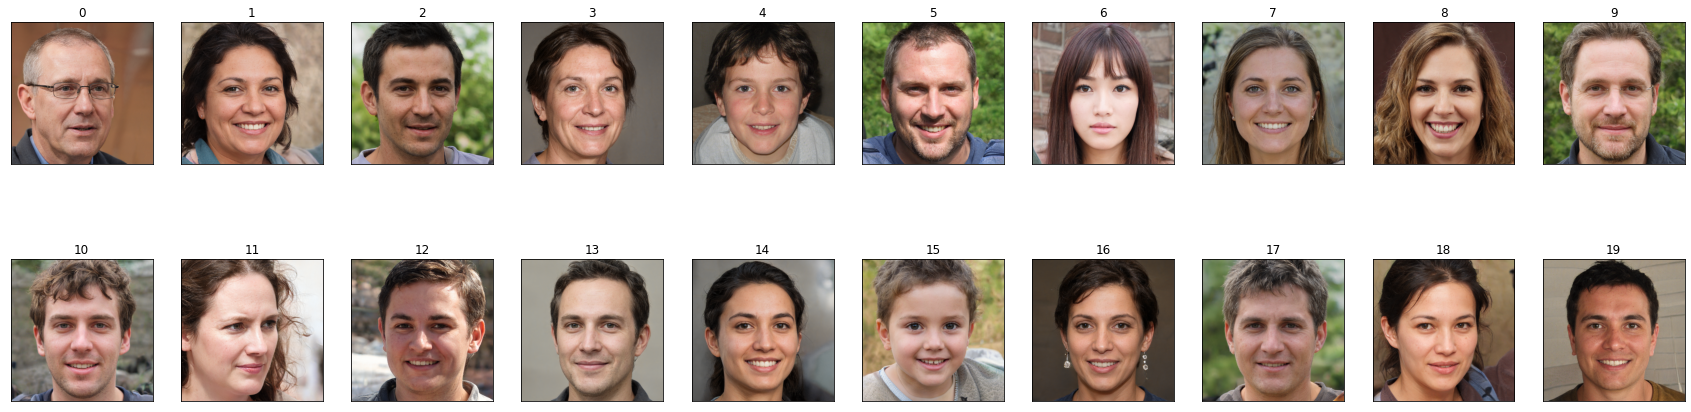

In [28]:
# Generate images

seeds = expand_seed( range(8000,8020), vector_size)
generate_images(Gs, seeds,truncation_psi=0.5)

plt.figure(figsize=(30,8))
for i, seed in enumerate(range(0,20)):
  plt.subplot(2,10,i+1)
  img = load_img("stylegan2/image"+str(i)+".png")
  imshow(img, i)
  plt.xticks([])
  plt.yticks([])

plt.show()

## Showing the effects of transforming the latent vector between two images.

![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.png "GAN")

Generating image for seed 0/2 ...
Generating image for seed 1/2 ...
(1, 512)


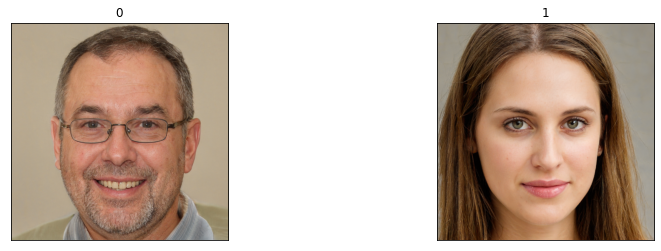

In [35]:
# Generating the edge pictures
seeds = expand_seed( [8192+1,8192+9], vector_size)
generate_images(Gs, seeds,truncation_psi=0.5)

plt.figure(figsize=(14,4))
for i, seed in enumerate(seeds):
  plt.subplot(1,2,i+1)
  img = load_img("stylegan2/image"+str(i)+".png")
  imshow(img, i)
  plt.xticks([])
  plt.yticks([])

print(seeds[0].shape)

We will generate a range of images that are similar to the above images within 300 steps

Generating image for seed 0/300 ...
Generating image for seed 1/300 ...
Generating image for seed 2/300 ...
Generating image for seed 3/300 ...
Generating image for seed 4/300 ...
Generating image for seed 5/300 ...
Generating image for seed 6/300 ...
Generating image for seed 7/300 ...
Generating image for seed 8/300 ...
Generating image for seed 9/300 ...
Generating image for seed 10/300 ...
Generating image for seed 11/300 ...
Generating image for seed 12/300 ...
Generating image for seed 13/300 ...
Generating image for seed 14/300 ...
Generating image for seed 15/300 ...
Generating image for seed 16/300 ...
Generating image for seed 17/300 ...
Generating image for seed 18/300 ...
Generating image for seed 19/300 ...
Generating image for seed 20/300 ...
Generating image for seed 21/300 ...
Generating image for seed 22/300 ...
Generating image for seed 23/300 ...
Generating image for seed 24/300 ...
Generating image for seed 25/300 ...
Generating image for seed 26/300 ...
Generating 

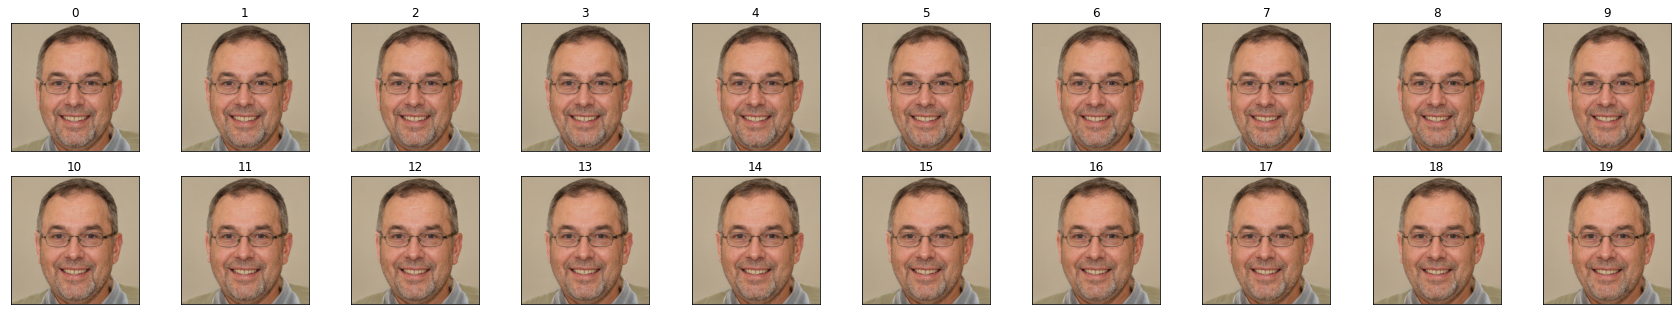

In [36]:

# 300 steps / frames
STEPS = 300
# difference between the 2 images (seeds)
diff = seeds[1] - seeds[0]
# We will go through the difference of the 2 images in 300 steps
step = diff / STEPS

# starts with the male image and ends with the female image
current = seeds[0].copy()

seeds2 = []
for i in range(STEPS):
  seeds2.append(current)
  current = current + step

generate_images(Gs, seeds2, truncation_psi=0.5)


300 images were generated. Let's see all images in a video


In [32]:
from google.colab import files
# Generate a video from the generated images
!ffmpeg -r 30 -i stylegan2/image%d.png -vcodec mpeg4 -y movie.mp4
files.
# Download generated video
files.download("movie.mp4")

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>